In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq

In [2]:
#%run -i "GPSoC/make_csv.py"

In [3]:
def get_data(measures):
    dfs = []
    for measure_id in measures:
        sql = """
        SELECT
          TRIM(Principal_Supplier) AS supplier,
          m.practice_id,
          m.pct_id,
          m.stp_id,
          m.regional_team_id,
          m.month,
          numerator,
          denominator
          --'{measure_id}' AS measure_id
        FROM
          measures.practice_data_{measure_id} m
        JOIN
          alex.vendors software
        ON
          software.ODS = practice_id
          AND Date = TIMESTAMP(m.month)
        JOIN
          hscic.practices
        ON
          practices.code = software.ODS
        JOIN
          hscic.practice_statistics
        ON
          practice_statistics.practice = practices.code
          AND Date = practice_statistics.month
        WHERE
          practices.setting = 4
          AND total_list_size > 100
          AND practices.status_code = 'A'
          AND denominator > 0
        ORDER BY
          month""".format(measure_id=measure_id)
        df = bq.cached_read(sql, csv_path='{}.zip'.format(measure_id))
        dfs.append(df)
    return dfs

measures = ['diltiazem','ciclosporin']
measure_tables = get_data(measures)
measure_tables[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288100 entries, 0 to 288099
Data columns (total 8 columns):
supplier            288100 non-null object
practice_id         288100 non-null object
pct_id              288100 non-null object
stp_id              288085 non-null object
regional_team_id    288085 non-null object
month               288100 non-null object
numerator           288100 non-null int64
denominator         288100 non-null int64
dtypes: int64(2), object(6)
memory usage: 17.6+ MB


In [4]:
demographics = pd.read_csv('data_for_regression_2019_10.csv')
demographics.head(3)

,practice,pct,LSOA11NM,ruc11cd,RUC11,mean_percentile,num_gps_june,num_gps_sept,CL,PH,...,TOTAL,Value_imd,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,code,dispensing_patients,total_items,list_size
0,A81001,00K,Stockton-on-Tees 014G,C,Urban city and town,0.446274,2.0,NaN,425.69,97.0,...,546.69,29.140310,83.627562,49.450467,23.323544,20.264317,A81001,0.0,94138.0,4097.083333
1,A81002,00K,Stockton-on-Tees 014F,C,Urban city and town,0.489142,12.0,12.0,435.00,97.0,...,559.00,29.689706,80.971049,58.535567,21.194615,18.908872,A81002,0.0,451497.0,19829.750000
2,A81003,00K,Hartlepool 007D,C,Urban city and town,NaN,NaN,NaN,425.34,97.0,...,549.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
merged_tables = []
i = 0
for measure in measure_tables:
    measure['month'] = pd.to_datetime(measure['month'])
    #last_yr = measure['month'].max() - pd.tseries.offsets.MonthBegin(12)
    df_last_yr = measure.loc[(measure['month']>='2018-01-01')&(measure['month']<='2018-12-01')]
    df_last_yr = df_last_yr.groupby(['supplier','practice_id','pct_id','stp_id','regional_team_id'], as_index=False).sum()
    df_last_yr['calc_value'] = df_last_yr['numerator'] / df_last_yr['denominator']
    merged = df_last_yr.merge(demographics, how='left',left_on='practice_id',right_on='practice')
    merged_tables.append(merged)
    print('{}_for_stata.csv'.format(measures[i]))
    merged.to_csv('{}_for_stata.csv'.format(measures[i]))
    i +=1

diltiazem_for_stata.csv
ciclosporin_for_stata.csv


In [6]:
from IPython.display import display, HTML

for measure in merged_tables:
    df = measure.groupby('supplier').mean()[['calc_value']]
    display(HTML(df.to_html()))

,calc_value
supplier,
EMIS,0.226804
Microtest,0.009950
TPP,0.069539
Vision,0.119647


,calc_value
supplier,
EMIS,0.232054
Microtest,0.060714
TPP,0.077601
Vision,0.107961


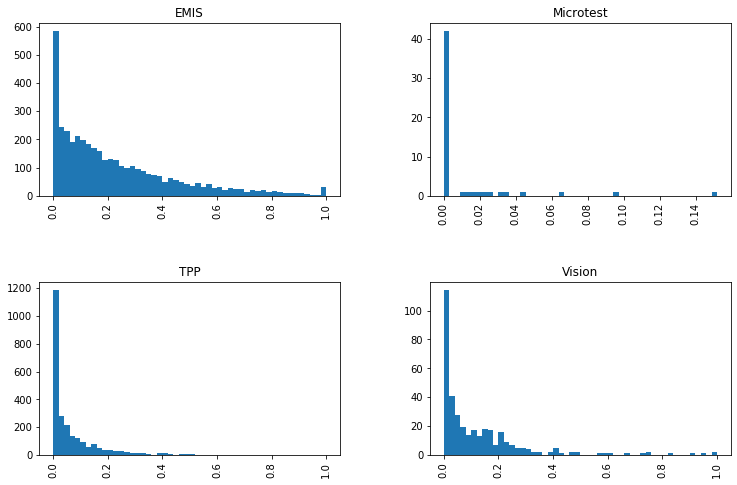

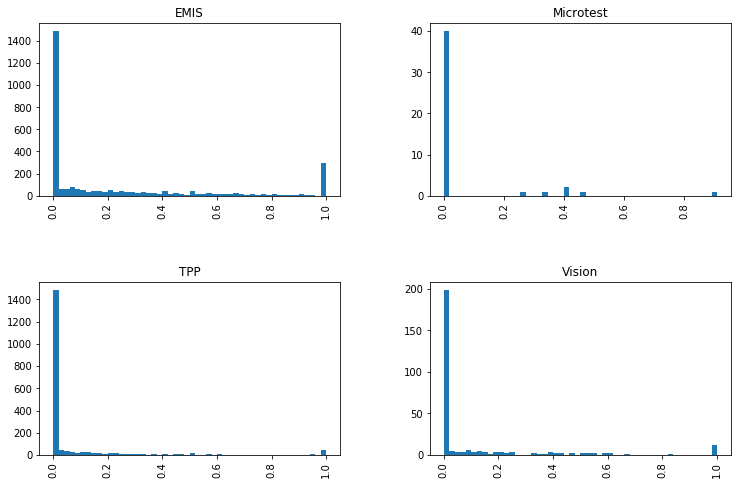

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

f = plt.figure(figsize=(12, 8))
ax = plt.subplot()
merged_tables[0][['calc_value','supplier']].hist(bins=50,by='supplier',ax=ax)
plt.show()

f = plt.figure(figsize=(12, 8))
ax2 = plt.subplot()
merged_tables[1][['calc_value','supplier']].hist(bins=50,by='supplier',ax=ax2)

ax.set_xlim(0,1)
plt.show()